In [1]:
import sys,os,importlib,gc,string
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm

os.chdir('/home/peter/Projects/tc_emulator/results')

sys.path.append('../scripts')
import _weather_pattern_class; importlib.reload(_weather_pattern_class)

atl = _weather_pattern_class.weather_patterns(source='ERA5', working_directory='./')

atl = _weather_pattern_class.weather_patterns(source='ERA5', working_directory='./')
atl.load_input('ERA5_VWS-MSLP_noTC3')
years = np.array(range(1982,2021))
atl.set_split(years=years)
nrows,ncols = 5,4
tag = 'SOM_pcaInit%sx%s_v1' % (nrows,ncols)
atl.define_plot_environment(pre_mapping='mapping_raw', clustering=tag, post_mapping='mapping_sammon_1982-2020', nrows=nrows, ncols=ncols)
atl.stats_TC(file='tracks/tracks_ibtracks.csv', overwrite=False)

{'SOM': <minisom.MiniSom object at 0x7fbd9d540610>}
.//ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/mapping_sammon_1982-2020/grid_5x4


In [2]:
years = np.arange(1982,2021,1)
# get sst
sst_MDR = xr.load_dataset('/home/peter/Projects/data/SST/OISST_sst_MDR_1981-2019_daily.nc')['sst']
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.year,years)]
sst_MDR = sst_MDR[np.isin(sst_MDR.time.dt.month,atl._months['mon'])]
sst_MDR = sst_MDR.assign_coords(time=np.array([str(d)[:10] for d in sst_MDR.time.values], np.datetime64))

# prepare tracks:
# here ssts are added. this will be needed in the wind component
atl._tracks = atl._tracks.loc[np.isin(atl._tracks.year,years)]
times = np.array([str(d)[:10] for d in atl._tracks.time.values], np.datetime64)
atl._tracks['time'] = np.array([str(d)[:10] for d in atl._tracks.time],np.datetime64)
atl._tracks['sst'] = sst_MDR.loc[times].values
atl._tracks['weather_0'] = atl._tracks['label_lag0']
tracks = atl._tracks.loc[np.isfinite(atl._tracks.weather_0)]
tracks = tracks.loc[tracks.distance > 0, ['weather_0','sst','wind','genesis','storm','ACE','year','storm_day','wind_before','month']]

# prepare gensis input
# this is a dataframe with an entry for each day
# this is required to get genesis probabilities
weather_sst = pd.DataFrame()
weather_sst['time'] =  np.array([str(d)[:10] for d in  atl._vector_time.values], np.datetime64)
weather_sst['year'] = atl._vector_time.dt.year
weather_sst['weather_0'] = atl._clust_labels
weather_sst['weather_1'] = np.roll(atl._clust_labels,1)
weather_sst['weather_2'] = np.roll(atl._clust_labels,2)
weather_sst['weather_3'] = np.roll(atl._clust_labels,3)
weather_sst = weather_sst.loc[np.isin(atl._vector_time.dt.year,years)]

genesis = weather_sst.copy()
genesis['genesis'] = [atl._tracks.loc[atl._tracks.time==np.datetime64(tt),'genesis'].sum() for tt in genesis.time]
genesis['sst'] = sst_MDR.sel(time=weather_sst.time.values)

weather_sst['sst'] = sst_MDR.sel(time=weather_sst.time.values)

genesis['day_in_season'] = 0
weather_sst['day_in_season'] = 0
for year in np.unique(weather_sst.time.dt.year):
    tttmmmppp = weather_sst.loc[(weather_sst.time.dt.year==year),'day_in_season']
    weather_sst.loc[(weather_sst.time.dt.year==year),'day_in_season'] = np.arange(tttmmmppp.shape[0])
    genesis.loc[(genesis.time.dt.year==year),'day_in_season'] = np.arange(tttmmmppp.shape[0])

weather_sst = weather_sst.loc[(weather_sst.day_in_season>=3) & np.isin(weather_sst.year,years)]
genesis = genesis.loc[(genesis.day_in_season>=3) & np.isin(genesis.year,years)]

In [3]:
# train test split by decades
train_test = pd.DataFrame()
train_test['year'] = list(range(1982,2021))
train_test['1982-1990'] = 'train'
train_test.loc[np.isin(train_test.year,np.arange(1982,1990+1)), '1982-1990'] = 'test'
train_test['1991-2000'] = 'train'
train_test.loc[np.isin(train_test.year,np.arange(1991,2000+1)), '1991-2000'] = 'test'
train_test['2001-2010'] = 'train'
train_test.loc[np.isin(train_test.year,np.arange(2001,2010+1)), '2001-2010'] = 'test'
train_test['2011-2020'] = 'train'
train_test.loc[np.isin(train_test.year,np.arange(2011,2020+1)), '2011-2020'] = 'test'

In [4]:
test_period = '2011-2020'
train_years = train_test.loc[train_test[test_period]=='train', 'year'].values
test_years = train_test.loc[train_test[test_period]=='test', 'year'].values
train_folder = atl._dir_lvl4 + '/emulator/' + str(test_period)+'/'

## Additional SST

In [5]:
# HadISST
sst_hist = xr.open_dataset('/home/peter/Projects/data/SST/HadISST_sst.nc')['sst'].loc[:,20:10,-90:-20]
lat_weight = np.cos(np.deg2rad(sst_hist.latitude.values))
lat_weight_array = np.repeat(lat_weight[np.newaxis,:], sst_hist.shape[2], 0).T
valid = np.isfinite(sst_hist[0,:,:].values)
sst_hist = xr.DataArray(np.nansum(sst_hist * lat_weight_array, axis=(1,2)) / np.sum(lat_weight_array[valid]), coords={'time':sst_hist.time}, dims=['time'])
hadisst_MDR = sst_hist[np.isin(sst_hist.time.dt.month,[8,9,10])].groupby('time.year').mean('time').loc[:2020]


# yearly SSTS for OISST
tmp = xr.load_dataset('/home/peter/Projects/data/SST/OISST_sst_MDR_1981-2019_daily.nc')['sst']
oisst_MDR = tmp.loc[np.isin(tmp.time.dt.month,[8,9,10])].groupby('time.year').mean('time')

(26.0, 29.0)

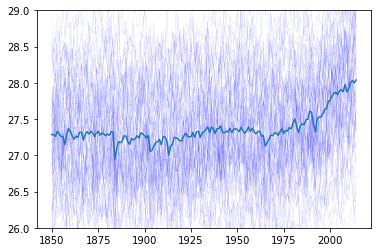

In [6]:
# CMIP6
%matplotlib inline
sst_cmip6 = xr.open_dataset('/home/peter/Projects/tc_emulator/results/SST_MDR_ASO_CMIP6.nc')['sst']
cmip6_MDR = sst_cmip6.mean('model').compute()

for mod in sst_cmip6.model.values:
    plt.plot(sst_cmip6.year, sst_cmip6.loc[mod,:], color='b', alpha=0.2, linewidth=0.3)
plt.plot(sst_cmip6.year,cmip6_MDR, label='CMIP6 median')   
plt.ylim(26,29)

In [7]:
sst_cmip6.model

<xarray.DataArray 'model' (model: 61)>
array(['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'AWI-ESM-1-1-LR',
       'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CAS-ESM2-0', 'CESM2',
       'CESM2-FV2', 'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 'CMCC-CM2-HR4',
       'CMCC-CM2-SR5', 'CMCC-ESM2', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'E3SM-1-0', 'E3SM-1-1',
       'E3SM-1-1-ECA', 'EC-Earth3', 'EC-Earth3-AerChem', 'EC-Earth3-CC',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'FGOALS-g3',
       'FIO-ESM-2-0', 'GFDL-CM4', 'GFDL-ESM4', 'GISS-E2-1-G', 'GISS-E2-1-G-CC',
       'GISS-E2-1-H', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'ICON-ESM-LR',
       'IITM-ESM', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM5A2-INCA', 'IPSL-CM6A-LR',
       'KACE-1-0-G', 'KIOST-ESM', 'MCM-UA-1-0', 'MIROC-ES2L', 'MIROC6',
       'MPI-ESM-1-2-HAM', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'MRI-ESM2-0',
       'NESM3', 'NorCPM1', 'NorESM2-LM', 'NorESM2-MM', 'SAM0-UNICON',
       'TaiESM1', 'UKESM1-0-LL'], dtype=object)
Coordinates:
    lon      float64 ...
    lat      float64 ...
  * model    (model) object 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'UKESM1-0-LL'

In [8]:
lr_cmip6 = sm.OLS(cmip6_MDR.loc[1982:].values, sm.add_constant(sst_cmip6.loc[:,1982:].year.values)).fit().params
lr_hadisst = sm.OLS(hadisst_MDR.loc[1982:].values, sm.add_constant(hadisst_MDR.loc[1982:].year.values)).fit().params
lr_oisst = sm.OLS(oisst_MDR.loc[1982:].values, sm.add_constant(oisst_MDR.loc[1982:].year.values)).fit().params

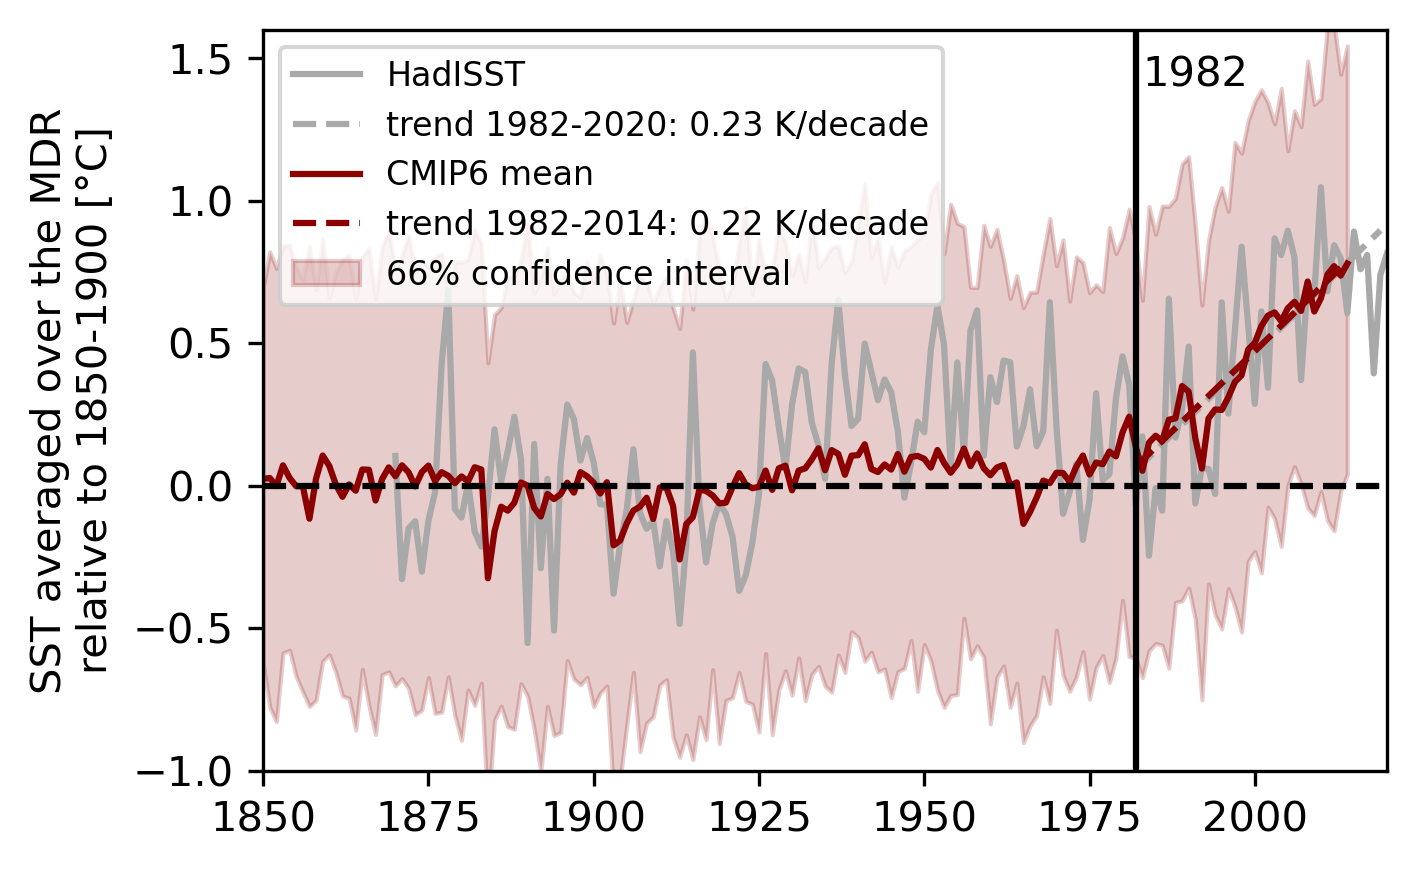

In [9]:
plt.close()
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3), dpi=300)
bounds = np.nanpercentile((sst_cmip6 - cmip6_MDR.loc[1850:1900].mean()).rolling(year=1, center=True).mean(),[17,83],axis=0).squeeze()
ax.fill_between(sst_cmip6.year, bounds[0,:], bounds[1,:], 
                 alpha=0.2, color='darkred', label='66% confidence interval', zorder=0)

for sst_raw,lr,color,label in zip([cmip6_MDR,hadisst_MDR][::-1],[lr_cmip6,lr_hadisst][::-1],
                              ['darkred','darkgray'][::-1],['CMIP6 mean','HadISST'][::-1]):
    
    shift = sst_raw.loc[1850:1900].mean().values
    sst = sst_raw - shift
    
    ax.plot(sst.year,sst,color=color, label=label,zorder=1)
    
    ax.plot(range(1982,sst.year.values[-1]), lr[0] - shift + lr[1] * range(1982,sst.year.values[-1]), color=color, linestyle='--',
             label='trend 1982-%s: %s K/decade' %(sst.year.values[-1],round(lr[1]*10,2)),zorder=1)
    # ax.plot([1982],[lr[0] + lr[1]*1982], marker='*', markerfacecolor=color, markeredgecolor='k', markersize=15,
    #              label='trend in 1982: %s K' %(np.round(lr[0] + lr[1]*1982,2)), linestyle='', zorder=10)

ax.axhline(y=0, color='k', linestyle='--')
ax.axvline(x=1982, color='k')
ax.annotate('1982', xy=(1983,1.4))
ax.set_ylabel('SST averaged over the MDR\nrelative to 1850-1900 [°C]')
ax.set_ylim(-1,1.6)
ax.legend(loc='upper left', fontsize=8)
ax.set_xlim(1850,2020)
plt.tight_layout()
plt.savefig('/home/peter/Projects/tc_emulator/written_latex/WCD/submission3/figures/SST_MDR_plot_1.png', dpi=600)

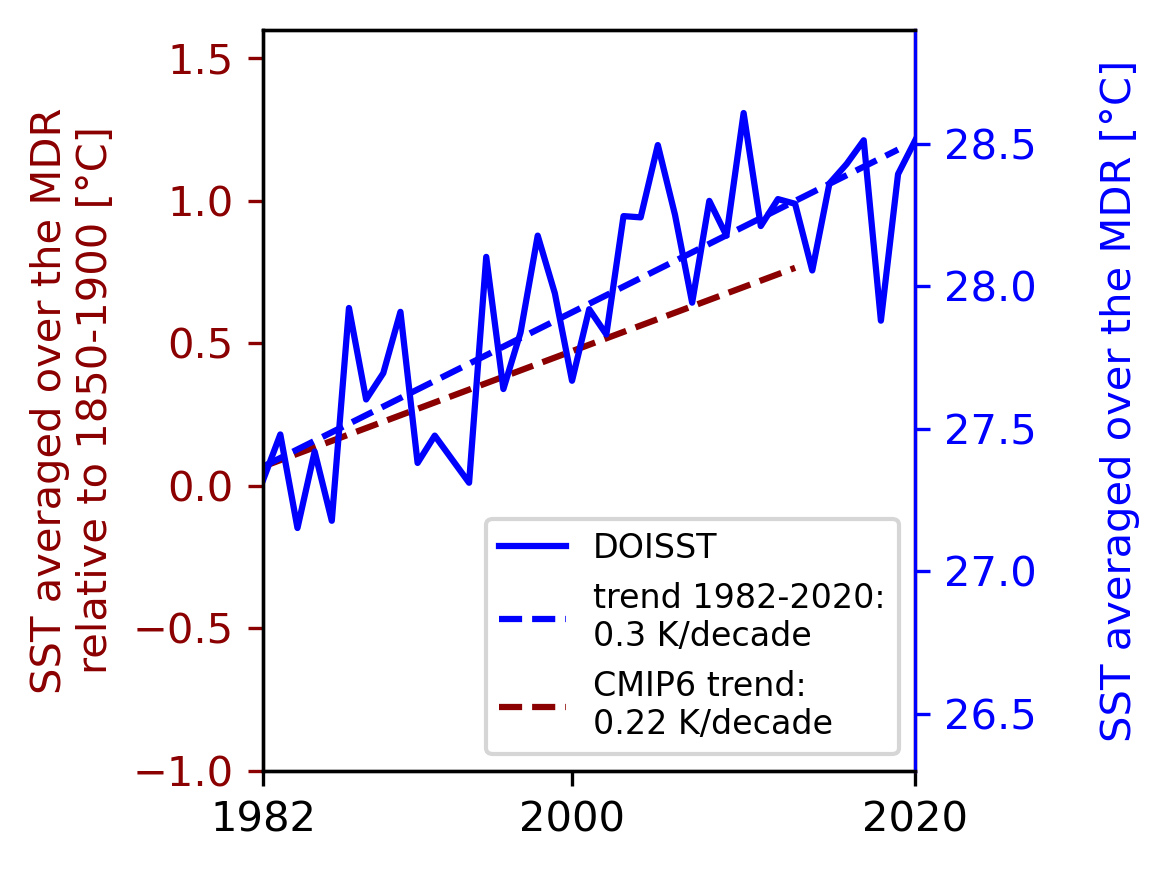

In [10]:
fig,ax0 = plt.subplots(nrows=1, ncols=1, figsize=(4,3), dpi=300)
ax = ax0.twinx()
ax.plot(oisst_MDR.year,oisst_MDR,color='b',label='DOISST')
ax.plot(range(1982,oisst_MDR.year.values[-1]), lr_oisst[0] + lr_oisst[1] * range(1982,oisst_MDR.year.values[-1]), color='b', linestyle='--',
             label='trend 1982-2020:\n%s K/decade' %(round(lr_oisst[1]*10,2)),zorder=1)
ax0.plot(range(1982,sst.year.values[-1]), lr_cmip6[0] - shift + lr_cmip6[1] * range(1982,sst.year.values[-1]), color=color, linestyle='--')
ax.plot([],[], color='darkred', linestyle='--', label='CMIP6 trend:\n%s K/decade' %(round(lr_cmip6[1]*10,2)),zorder=1)
ax.set_ylim(lr_oisst[0] + lr_oisst[1]*1982 - (lr[0] - shift + lr[1]*1982) - 1, 
            lr_oisst[0] + lr_oisst[1]*1982 - (lr[0] -shift + lr[1]*1982) - 1 + 2.6)
ax.spines['right'].set_color('b')
ax.yaxis.label.set_color('b')
ax.tick_params(axis='y', colors='b')
ax.set_xticks([1982,2000,2020])
ax.set_xlim(1982,2020)
ax0.set_ylim(-1,1.6)
ax0.spines['right'].set_color('darkred')
ax0.yaxis.label.set_color('darkred')
ax0.tick_params(axis='y', colors='darkred')
ax0.set_ylabel('SST averaged over the MDR\nrelative to 1850-1900 [°C]')
ax.set_ylabel('\nSST averaged over the MDR [°C]')
ax.legend(loc='lower right', fontsize=8)
plt.tight_layout()
plt.savefig('/home/peter/Projects/tc_emulator/written_latex/WCD/submission3/figures/SST_MDR_plot_2.png', dpi=600)

In [11]:
detrend = oisst_MDR - (lr_cmip6[1] * oisst_MDR.year + lr_cmip6[0])
lr_detrend = sm.OLS(detrend.loc[1982:2020].values, sm.add_constant(detrend.loc[1982:2020].year.values)).fit().params

sst_counterfacts = {'ref':oisst_MDR}
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * 1982
sst_counterfacts['1982'] = cou
cou = detrend + lr_cmip6[0] + lr_cmip6[1] * 2020
sst_counterfacts['2020'] = cou

In [12]:
lr_cmip6[1] * (2020-1982)

0.8549371533276006

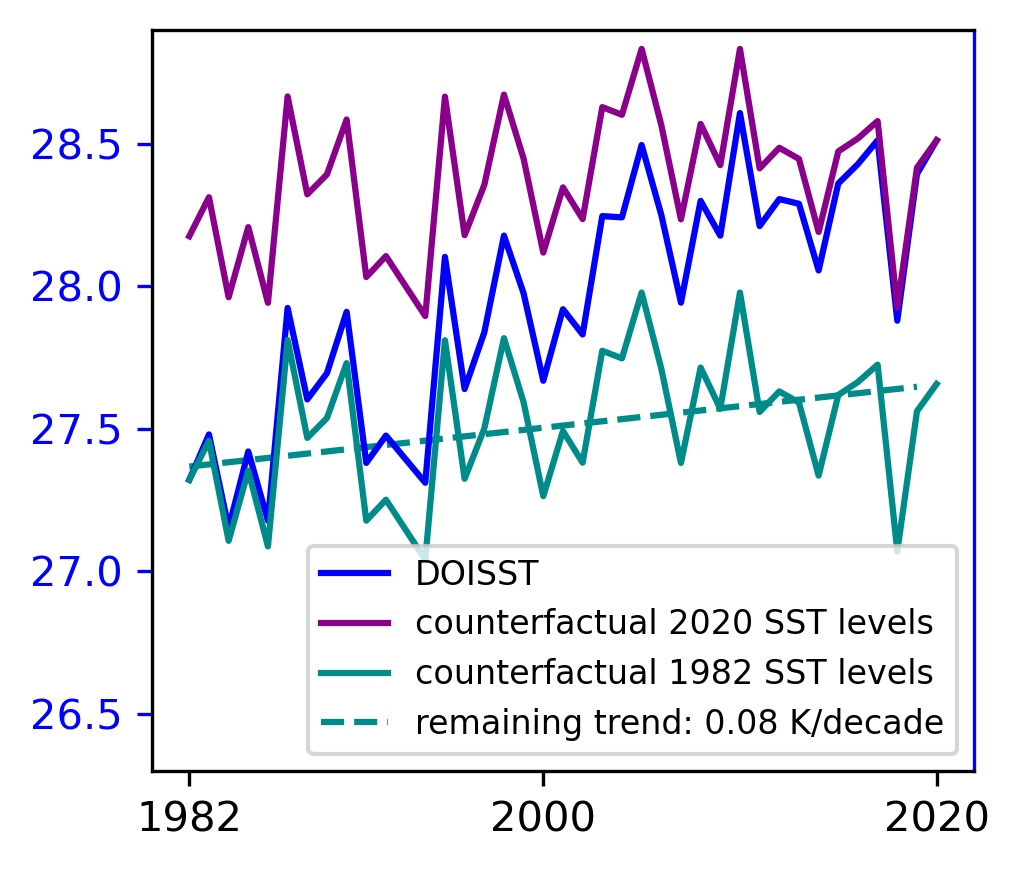

In [13]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(3.5,3), dpi=300)

ax.plot(oisst_MDR.year, oisst_MDR, color='b', label='DOISST')
ax.plot(oisst_MDR.year, sst_counterfacts['2020'], color='darkmagenta', label="counterfactual 2020 SST levels")
ax.plot(oisst_MDR.year, sst_counterfacts['1982'], color='darkcyan', label="counterfactual 1982 SST levels")
plt.plot(range(1982,2020), lr_detrend[0] + lr_detrend[1] * range(1982,2020) + lr_cmip6[0] + lr_cmip6[1] * 1982, 
         color='darkcyan', linestyle='--', label='remaining trend: %s K/decade' %(round(lr_detrend[1]*10,2)),zorder=1)

ax.set_ylim(lr_oisst[0] + lr_oisst[1]*1982 - (lr[0] - shift + lr[1]*1982) - 1, 
            lr_oisst[0] + lr_oisst[1]*1982 - (lr[0] -shift + lr[1]*1982) - 1 + 2.6)
ax.spines['right'].set_color('b')
ax.yaxis.label.set_color('b')
ax.tick_params(axis='y', colors='b')
ax.set_xticks([1982,2000,2020])
ax.legend(loc='lower right', fontsize=8)
# ax.set_ylabel('detrended SST\naveraged over the MDR [°C]')
plt.tight_layout()
plt.savefig('/home/peter/Projects/tc_emulator/written_latex/WCD/submission3/figures/SST_MDR_plot_3.png', dpi=600)

In [14]:
lr_cmip6

array([-17.26299963,   0.02249835])

In [15]:
# choose components
alphabet = iter(list(string.ascii_lowercase))
comps_todo = [
    {'g':'gWeaLag2Weight', 'sL':'sLWeaNeigh', 'wS':'wS100nnQrSST', 'Emu':'Emu0', 'name':'main','l':next(alphabet),'c':'c'},
    ]
N = 1000
years = range(1982,2021)
overwrite = False
for dt in comps_todo:
    tag = '_'.join([dt[k] for k in ['g','sL','wS','Emu']])
    print(tag)
    import _emulator; importlib.reload(_emulator); from _emulator import *
    for k,v in {k:v for k,v in dt.items() if k in ['g','sL','wS','Emu']}.items():
        exec("import %s; importlib.reload(%s); from %s import *" % tuple(['components.'+k+'.'+v]*3))
    genesis_obj = pickle.load(open(train_folder+'/_comp_g_'+dt['g']+'/genesis_obj.pkl', 'rb'))
    end_obj = pickle.load(open(train_folder+'/_comp_sL_'+dt['sL']+'/end_obj.pkl', 'rb'))
    wind_obj = pickle.load(open(train_folder+'/_comp_wS_'+dt['wS']+'/wind_obj.pkl', 'rb'))
    emu = storm_emulator(dir=train_folder, tag=tag, emulate_season_function=emulate_season_function)
    emu._weather_sst = weather_sst
    emu.get_stats_seasonal_obs(tracks, train_test.year.values)
    counterFacts = {}
    # all decades .....
    for scenario in ['1982','2020']:
        for year in years:
            sst_diff_counterfactual = (sst_counterfacts[scenario].loc[year] - sst_counterfacts['ref'].loc[year]).values    
            # print(scenario,year,sst_diff_counterfactual)
            emu.simulate_sst_counterfactual(name='_%s_shift%s' %(year,scenario), years=[year], sst_shift=sst_diff_counterfactual, N=N, genesis_obj=genesis_obj, wind_obj=wind_obj, end_obj=end_obj, overwrite=overwrite)
            # merged
            if year == 1982:
                counterFacts['%s SST levels' %(scenario)] = emu._simu
                counterFacts['%s SST levels' %(scenario)]['sst'] = xr.DataArray(coords={'year':years}, dims=['year'])
            else:
                for indicator in emu._simu.keys():
                    counterFacts['%s SST levels' %(scenario)][indicator] = xr.concat((counterFacts['%s SST levels' %(scenario)][indicator], emu._simu[indicator]), dim='year')

            counterFacts['%s SST levels' %(scenario)]['sst'].loc[year] = weather_sst.loc[weather_sst.year == year, 'sst'].mean() + sst_diff_counterfactual

gWeaLag2Weight_sLWeaNeigh_wS100nnQrSST_Emu0


In [16]:
# counterFacts['%s SST levels' %(1900)].update({'color':'gray', 'lsty':':', 's':-0.3, 'label':'pre-industrial\nSST levels'})
counterFacts['%s SST levels' %('1982')].update({'color':'darkcyan', 'lsty':'--', 's':-0.0, 'label':'1982\nSST levels'})
counterFacts['%s SST levels' %('2020')].update({'color':'darkmagenta', 'lsty':'-', 's':0.3, 'label':'2020\nSST levels'})
# counterFacts['%s SST levels' %('ref')].update({'color':'k', 'lsty':'-', 's':0.1, 'label':'observed\nSSTs'})

In [17]:
    os.system('mkdir '+emu._dir+'/'+emu._tag+'/counter_2011-2020/')
    all_years = np.arange(1982,2021,1)

    year_groups = {
        0 : {'years':all_years, 'color':'blue', 'label':'all years', 'lsty':'-', 'eva':0.5, 'short':'all years'},
        1 : {'years':[yr for yr in years if float(counterFacts['2020 SST levels']['ACE'].loc[yr].mean('run').values) >= 126.1], \
                    'color':'red', 'label':'favorable large scale conditions', 'lsty':'--', 'eva':0.3, 'short':'favorable'},
        # 2 : {'years':[yr for yr in all_years if float(counterFacts['all_2009-2018SST'][indicator].loc[yr].mean('run').values) < 126.1], \
                      # 'color':'darkgreen', 'label':'unfavorable large scale conditions', 'lsty':':', 'eva':-0.2, 'short':'un-favorable'},
        # '2017' : {'years':[2017], 'color':'m', 'label':'2017', 'lsty':'-.', 'eva':0.4},
    }
    ##############################
    # seasonal ACE probabilities #
    ##############################
    plt.close('all')
    plt.rc('grid', linestyle="--", color='lightgray')
    fig,axes = plt.subplots(nrows=4, ncols=2, figsize=(8,6), dpi=100, facecolor='w', sharex='col', sharey='row', gridspec_kw={'height_ratios':[5,5,2,2], 'width_ratios':[5,1]}, constrained_layout=True)
    for ax in axes.flatten()[1:]:
        ax.grid(zorder=0)
    indicator = 'ACE'
    axSST = axes[0,0]
    axSST.fill_between([1982,2020],[27.16]*2,[28.62]*2, color='gray', alpha=0.3)
    axSST.set_ylabel('SST averaged\nover the MDR [°C]')
    axM = axes[1,0]
    # tmpCur = counterFacts['all_2009-2018SST'][indicator]
    for scen,DT in counterFacts.items():
        axSST.plot(DT['sst'].year, DT['sst'], color=DT['color'])
        print('%s SST average %s' %(scen, DT['sst'].mean()))

    axL = axes[0,1]
    axL.axis('off')
    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        DT = counterFacts[scen]
        axL.plot([],[], color=DT['color'], label=DT['label'])
    axL.legend(fontsize=8)

    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        DT = counterFacts[scen]
        tmp = DT[indicator]
        # for q,lsty in zip([50,95],['--','-','-','-.']):
            # axM.plot(tmp.year, np.nanpercentile(tmp, q, axis=1), color=DT['color'], linestyle=lsty)

        for iyr,yr in enumerate(tmp.year.values):
            if DT['sst'][iyr] < 27.16 or DT['sst'][iyr] > 28.62:
                alpha=0.2
            else:
                alpha=1
            pctls = np.nanpercentile(tmp.loc[yr], [5,17,50,83,95])
            x=DT['s'] + yr
            axM.fill_between([x-0.1,x+0.1],[pctls[1]]*2, [pctls[3]]*2, color=DT['color'], alpha=alpha, zorder=3)
            axM.plot([x,x], pctls[[0,-1]], color=DT['color'], alpha=alpha, zorder=3)
            axM.plot([x-0.1,x+0.1],[pctls[2]]*2, color='w', zorder=4)


        for x,yrDT in year_groups.items():
            x += DT['s']
            pctls = np.nanpercentile(tmp.loc[np.isin(tmp.year,yrDT['years'])], [5,17,50,83,95])
            print(scen,yrDT['label'],pctls)
            axes[1,1].fill_between([x-0.1,x+0.1],[pctls[1]]*2, [pctls[3]]*2, color=DT['color'], alpha=alpha, zorder=3)
            axes[1,1].plot([x,x], pctls[[0,-1]], color=DT['color'], alpha=alpha, zorder=3)
            axes[1,1].plot([x-0.1,x+0.1],[pctls[2]]*2, color='w', zorder=4)

        # for yr in tmp.year.values:
        #     axM.scatter([yr]*1000, tmp.loc[yr], color=DT['color'], alpha=0.1, s=7)
    axes[-1,1].set_xticks(list(year_groups.keys()))
    axes[-1,1].set_xticklabels([d['short'] for d in year_groups.values()], rotation=90)
    # axes[0,0].set_xlim(0.9,1.1)

    aces = [[126.1, 2, 'orange','above normal seasons (ACE > 126.1)'], [159.6, 3, 'red','extremely active seasons (ACE > 159.6)']]
    for ace,r,color,name in aces:
        axes[r,1].set_ylim(0,100)
        axes[r,1].set_yticks(np.arange(0,110,25))
        axes[r,0].set_title(name, color=color)
        axes[r,0].set_ylabel('[$\%$]', color=color)
        for ax in axes[r,:]:
            ax.tick_params(axis='y', colors=color)
            for child in ax.get_children():
                if isinstance(child, matplotlib.spines.Spine):
                    child.set_color(color)
        for ax in axes[1,:]:
            ax.axhline(ace, color=color, zorder=2)
        for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
            DT = counterFacts[scen]
            tmp = DT[indicator]
            for yr in tmp.year.values:
                y = np.sum(tmp.loc[yr]>ace).values / tmp.loc[yr].values.flatten().shape[0] * 100
                axes[r,0].bar(x=yr,height = y, color=DT['color'], zorder=2)

            for x,yrDT in year_groups.items():
                tmp_ = tmp[np.isin(tmp.year,yrDT['years']),:]
                y = np.sum(tmp_>ace).values / tmp_.values.flatten().shape[0] * 100
                print(ace,scen,yrDT['label'],y)
                axes[r,1].bar(x=x,height = y, color=DT['color'], zorder=2)

    axes[1,0].set_ylim(0,300)
    axes[1,0].set_yticks([0,50,90,126.1,159.6,200,250,300])
    axes[1,0].get_yticklabels()[3].set_color('orange')
    axes[1,0].get_yticklabels()[4].set_color('red')
    axes[1,0].set_ylabel('ACE [m2/s2]')
    axes[-1,0].set_xticks(np.arange(1982,2022,2))
    axes[-1,0].set_xticklabels(np.arange(1982,2022,2), rotation=90)

    for ax,letter in zip(axes.flatten()[[0]+list(range(2,8))],list(string.ascii_lowercase)):
        ax.annotate(letter, xy=(0,0.95), xycoords='axes fraction', fontweight='bold', fontsize=16, backgroundcolor='w')

    plt.tight_layout()
    plt.savefig(emu._dir+'/'+emu._tag+'/counter_2011-2020/'+indicator+'_yearly_probs.png', bbox_inches='tight', dpi=200); plt.close()


mkdir: cannot create directory ‘.//ERA5_VWS-MSLP_noTC3/mapping_raw_1982-2020/SOM_pcaInit5x4_v1/mapping_sammon_1982-2020/grid_5x4/emulator/2011-2020//gWeaLag2Weight_sLWeaNeigh_wS100nnQrSST_Emu0/counter_2011-2020/’: File exists


1982 SST levels SST average <xarray.DataArray ()>
array(27.52971829)
2020 SST levels SST average <xarray.DataArray ()>
array(28.38465545)
2020 SST levels all years [ 28.4    51.32  101.24  176.08  241.562]
2020 SST levels favorable large scale conditions [ 70.92   103.32   159.92   228.9668 286.886 ]
1982 SST levels all years [ 22.32  39.6   78.96 138.16 190.56]
1982 SST levels favorable large scale conditions [ 55.    81.4  124.88 180.24 228.32]


126.1 2020 SST levels all years 36.27948717948718
126.1 2020 SST levels favorable large scale conditions 70.6
126.1 1982 SST levels all years 21.55897435897436
126.1 1982 SST levels favorable large scale conditions 48.97857142857143
159.6 2020 SST levels all years 22.253846153846155
159.6 2020 SST levels favorable large scale conditions 50.17857142857143
159.6 1982 SST levels all years 10.52051282051282
159.6 1982 SST levels favorable large scale conditions 26.535714285714285


In [18]:
    year_groups = {
        0 : {'years':all_years, 'color':colors[0], 'label':'all years', 'lsty':'-', 'eva':0.5, 'short':'all years'},
        # 1 : {'years':[yr for yr in years if float(counterFacts['2020 SST levels']['ACE'].loc[yr].mean('run').values) >= 126.1], \
        #             'color':'red', 'label':'favorable large scale conditions', 'lsty':'--', 'eva':0.3, 'short':'favorable'},
        2005 : {'years':[2005], 'color':colors[1], 'label':'2005', 'lsty':'-.', 'eva':0.4},
        2020 : {'years':[2020], 'color':colors[2], 'label':'2020', 'lsty':'-.', 'eva':0.4},
        1983 : {'years':[1983], 'color':colors[3], 'label':'1983', 'lsty':'-.', 'eva':0.4},
    }
    indicator_dict = {
        # 'ACE225' : {'name':'ACE','label':'ACE', 'threshold':225},
        'ACE178' : {'name':'ACE','label':'ACE', 'threshold':178},
        # 'ACE159.6' : {'name':'ACE','label':'ACE', 'threshold':159.6},
        # 'ACE126.1' : {'name':'ACE','label':'ACE', 'threshold':126.1},
        # 'MajHur' : {'name':'MajHur', 'label':'major hurricanes', 'threshold':4.5},
        # 'Hur' : {'name':'Hur','label':'hurricanes', 'threshold':9.2},
    }
    ##################################
    # CDFs with difference highlight #
    ##################################
    for ind,indDT in indicator_dict.items():
        indicator = indDT['name']
        threshold = indDT['threshold']
        tmp = np.concatenate([d[indicator].values.flatten() for d in counterFacts.values()])
        X = np.linspace(tmp.min(),tmp.max(),1000)
        bw = (tmp.max() - tmp.min()) / 20

        plt.close()
        fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(8,3), dpi=300)
        ax = axes[0]

        for tr,lsty in zip([threshold,126.1,159.6],['-',':','--']):
            ax.axvline(x=tr, color='gray', linestyle=lsty)
            # ax.annotate(tr, xy=(tr, 0), rotation=90, ha='center', va='bottom', fontsize=8, backgroundcolor='w')

        intersects = pd.DataFrame()
        for yrName,yrDT in year_groups.items():
            ys = []
            for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
                DT = counterFacts[scen]
                tmp = DT[indicator][np.isin(DT[indicator].year,yrDT['years'])].values.reshape(-1, 1)
                kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(tmp)
                log_dens = kde.score_samples(X.reshape(-1, 1))
                y = np.exp(log_dens) / np.exp(log_dens).sum()
                ax.plot(X, np.cumsum(y), color=yrDT['color'], linestyle=DT['lsty'], zorder=10)
                ys.append(np.cumsum(y))

            ax.fill_between(X, ys[0], ys[1], color=yrDT['color'], alpha=0.3, zorder=10)

        for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
            DT = counterFacts[scen]
            ax.plot([],[],color='k', linestyle=DT['lsty'], label=DT['label'])

        for yrName,yrDT in year_groups.items():
            ax.plot([],[],color=yrDT['color'], label=yrDT['label'])

        ax.set_xlabel(indDT['label'])
        ax.set_xlim(0,400)
        ax.annotate('observed\nin 2020', xy=(178, 0.04), color='gray', va='center',fontsize=8, 
             xycoords='data',xytext=(220, 0.04), textcoords='data',
             arrowprops=dict(arrowstyle= '-|>',
                             color='gray',lw=1.5,ls='-'))
        ax2 = ax.twiny()
        ax2.set_xlim(0,400)
        ax2.set_xticks([126.1,159.6,178])
        ax2.set_xticklabels([126.1,159.6,178], rotation=90, ha='center', fontsize=8)
        ax2.get_xticklabels()[0].set_color('gray')
        ax2.get_xticklabels()[1].set_color('gray')
        ax.legend(fontsize=8, loc='center right')

        ax.annotate('a', xy=(-0.1,1.2), xycoords='axes fraction', fontweight='bold', backgroundcolor='w', ha='left', va='top', fontsize=12)
        # plt.savefig(emu._dir+'/'+emu._tag+'/counter_2011-2020/'+indicator+'_cdf_thresh'+str(threshold)+'.png', bbox_inches='tight', dpi=400); plt.close()
        # plt.show()

        ############
        # FAR 2017 #
        ############
        N = 1000
        indicator = indDT['name']
        threshold = indDT['threshold']

        ax=axes[1]
        
        ref = counterFacts['%s SST levels' %(2020)][indicator]
        for scen in ['%s SST levels' %(yr) for yr in [1982]]:
            DT = counterFacts[scen]
            counter = DT[indicator]
            for yrName,yrDT in year_groups.items():
                yrs = yrDT['years']
                FAR,IR = [],[]
                for i in range(N):
                    probRef = np.sum(np.random.choice(ref[np.isin(ref.year,yrs)].values.flatten(), size=int(0.5*N), replace=True) >= threshold) / (0.5*N)
                    probCounter = np.sum(np.random.choice(counter[np.isin(counter.year,yrs)].values.flatten(), size=int(0.5*N), replace=True) >= threshold) / (0.5*N)
                    FAR.append(1 - probCounter / probRef)
                    IR.append(probRef / probCounter)
                if '1982' in scen:
                    ax.hist(FAR, bins=np.linspace(0,1,20), density=True, linestyle=DT['lsty'], color=yrDT['color'], alpha=0.5)

                probRef = np.sum(ref[np.isin(ref.year,yrs)].values.flatten() >= threshold) / len(ref[np.isin(ref.year,yrs)].values.flatten())
                probCounter = np.sum(counter[np.isin(ref.year,yrs)].values.flatten() >= threshold) / len(counter[np.isin(ref.year,yrs)].values.flatten())
                FAR = 1 - probCounter / probRef
                print('%s %s FAR %s factor %s' %(ind,yrName, FAR*100, 1/(1-FAR)))
                ax.axvline(x=FAR, linestyle=DT['lsty'], color=yrDT['color'])#, label=yrDT['label'])

#         ax.plot([],[],color='w', label='counterfactual scenario')
#         for scen in ['%s SST levels' %(yr) for yr in [1982]]:
#             DT = counterFacts[scen]
#             ax.plot([],[],color='k', linestyle=DT['lsty'], label=DT['label'])

#         ax.plot([],[],color='w', label='weather conditions')
#         for yrName,yrDT in year_groups.items():
#             ax.plot([],[],color=yrDT['color'], label=yrDT['label'])

        ax.set_xlabel('Fraction of risk attributable to SST warming')
        ax.set_ylabel('estimated likelihood (normalized)')
        ax.set_ylim(0,5)
        ax2 = ax.twiny()
        ax2.set_xticks([0.5,0.75,0.9])
        ax2.set_xticklabels(['%sx' %(i) for i in [2,4,10]])
        ax2.set_xlabel('Increase in risk')
        # ax.legend(fontsize=6, bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.annotate('b', xy=(-0.1,1.2), xycoords='axes fraction', fontweight='bold', backgroundcolor='w', ha='left', va='top', fontsize=12)
        plt.savefig(emu._dir+'/'+emu._tag+'/counter_2011-2020/'+indicator+'_far_special_thresh'+str(threshold)+'.png', bbox_inches='tight', dpi=200)
        plt.show()


NameError: name 'colors' is not defined

In [19]:
# average ACE
for x,yrDT in year_groups.items():
    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        tmp = counterFacts[scen]['ACE']
        tmp = tmp[np.isin(tmp.year,yrDT['years'])]
        print('%s %s %s' %(scen, yrDT['short'], tmp.mean().values))

2020 SST levels all years 113.89165128205128
1982 SST levels all years 89.04507384615384
2020 SST levels favorable 166.93454571428572
1982 SST levels favorable 131.14976857142858


In [20]:
# percentage of above 126.1 ACE seasons that would not have occurred in other sceanrio
for ACE in [126.1,159.6]:
    for scen in ['%s SST levels' %(yr) for yr in [1982]]:
        pact = np.sum(counterFacts['%s SST levels' %(2020)]['ACE'] > ACE) / counterFacts['%s SST levels' %(2020)]['ACE'].values.flatten().shape[0]
        ppreind = np.sum(counterFacts[scen]['ACE'] > ACE) / counterFacts[scen]['ACE'].values.flatten().shape[0]
        print(pact.values,ppreind.values)
        print(pact.values/ppreind.values)
        print('percentage of above %s ACE seasons that would not have happened in %s %s '
              %(ACE, scen, (1 - ppreind.values / pact.values) * 100))

0.3627948717948718 0.2155897435897436
1.6828020932445291
percentage of above 126.1 ACE seasons that would not have happened in 1982 SST levels 40.57530567531275 
0.22253846153846155 0.1052051282051282
2.115281501340483
percentage of above 159.6 ACE seasons that would not have happened in 1982 SST levels 52.72496831432193 


In [21]:
# chance of 2020 becoming above average in different scenarios
for ACE in [126.1,159.6,178]:
    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        ppreind = np.sum(counterFacts[scen]['ACE'].loc[2020] > ACE) / counterFacts[scen]['ACE'].loc[2020].values.flatten().shape[0] * 100
        print('percentage of above %s ACE seasons in %s %s ' %(ACE, scen, ppreind.values))

percentage of above 126.1 ACE seasons in 2020 SST levels 78.3 
percentage of above 126.1 ACE seasons in 1982 SST levels 61.1 
percentage of above 159.6 ACE seasons in 2020 SST levels 60.4 
percentage of above 159.6 ACE seasons in 1982 SST levels 33.0 
percentage of above 178 ACE seasons in 2020 SST levels 47.099999999999994 
percentage of above 178 ACE seasons in 1982 SST levels 21.2 


In [22]:
# average ACE 1982-1994
for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
    DT = counterFacts[scen]
    print('%s 1982:1994 %s' %(scen, DT['ACE'].loc[1982:1994,:].mean().values))
    print('%s %s' %(scen, DT['ACE'].mean().values))


2020 SST levels 1982:1994 78.96564615384615
2020 SST levels 113.89165128205128
1982 SST levels 1982:1994 60.93319384615385
1982 SST levels 89.04507384615384


In [23]:
# ACE in 2020
for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
    DT = counterFacts[scen]
    print('%s 2020 %s' %(scen, DT['ACE'].loc[2020,:].mean().values))
    # print('%s %s' %(scen, DT['ACE'].mean().values))

2020 SST levels 2020 176.85244
1982 SST levels 2020 142.90304000000003


In [24]:
from distinctipy import distinctipy
colors = distinctipy.get_colors(4)

In [25]:
print('prob of 178 ACE')
for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
    DT = counterFacts[scen]
    tmp = DT['ACE']
    print('%s : %s' %(scen, np.sum(tmp > 178).values / tmp.values.flatten().shape[0] * 100))


prob of 178 ACE
2020 SST levels : 16.441025641025643
1982 SST levels : 6.817948717948719


In [26]:
16.44/6.82

2.410557184750733

In [27]:
for ace in [126.1,159.6,178]:
    print('prob of %s ACE with 2020 conditions' %(ace))
    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        DT = counterFacts[scen]
        tmp = DT['ACE'].loc[2020]
        print('%s : %s' %(scen, np.sum(tmp > ace).values / tmp.values.flatten().shape[0] * 100))


prob of 126.1 ACE with 2020 conditions
2020 SST levels : 78.3
1982 SST levels : 61.1
prob of 159.6 ACE with 2020 conditions
2020 SST levels : 60.4
1982 SST levels : 33.0
prob of 178 ACE with 2020 conditions
2020 SST levels : 47.099999999999994
1982 SST levels : 21.2


In [28]:
for year in [1983,1985,2005,2020]:
    print('prob of 178 ACE with %s conditions' %(year))
    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        DT = counterFacts[scen]
        tmp = DT['ACE'].loc[year]
        print('%s : %s' %(scen, np.sum(tmp > 178).values / tmp.values.flatten().shape[0] * 100))


prob of 178 ACE with 1983 conditions
2020 SST levels : 0.0
1982 SST levels : 0.0
prob of 178 ACE with 1985 conditions
2020 SST levels : 0.8
1982 SST levels : 0.0
prob of 178 ACE with 2005 conditions
2020 SST levels : 59.8
1982 SST levels : 37.9
prob of 178 ACE with 2020 conditions
2020 SST levels : 47.099999999999994
1982 SST levels : 21.2


In [29]:
47/21

2.238095238095238

## simpler fig 6

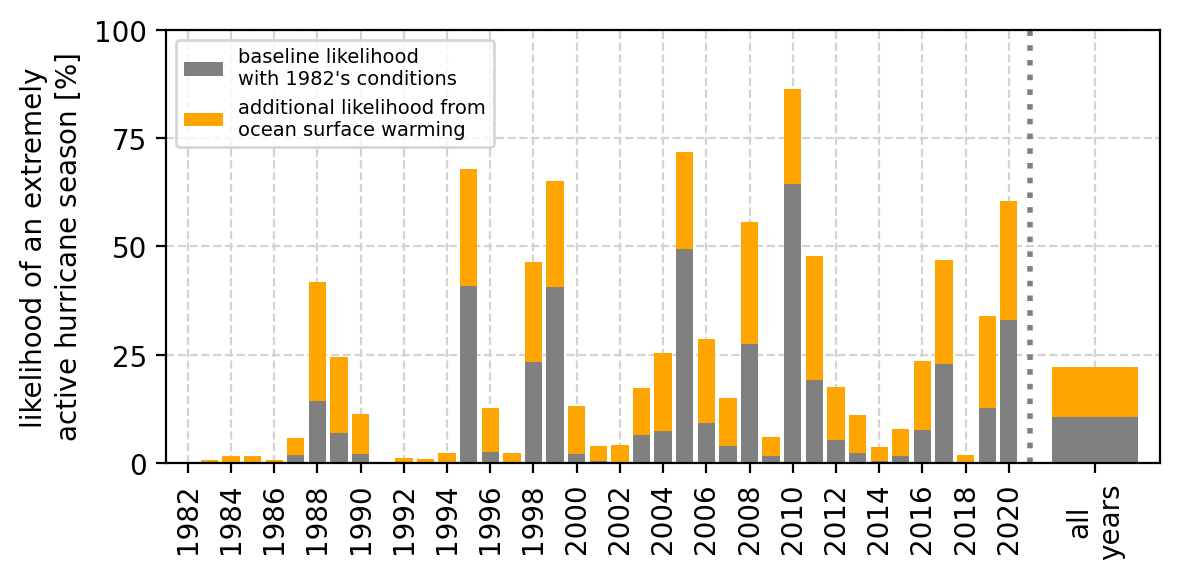

In [30]:
counterFacts['%s SST levels' %('1982')]['color'] = 'gray'
counterFacts['%s SST levels' %('2020')]['color'] = 'orange'
all_years = np.arange(1982,2021,1)

year_groups = {
    0 : {'years':all_years, 'color':'blue', 'label':'all years', 'lsty':'-', 'eva':0.5, 'short':'all years'},
}
plt.close('all')
plt.rc('grid', linestyle="--", color='lightgray')
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), dpi=200, facecolor='w', sharey='row',
                            constrained_layout=True)
indicator = 'ACE'

aces = [[159.6, 3, 'red','extremely active seasons (ACE > 159.6)']]
for ace,r,color,name in aces:
    for scen in ['%s SST levels' %(yr) for yr in [2020,1982]]:
        DT = counterFacts[scen]
        tmp = DT[indicator]
        for yr in tmp.year.values:
            y = np.sum(tmp.loc[yr]>ace).values / tmp.loc[yr].values.flatten().shape[0] * 100
            ax.bar(x=yr,height = y, color=DT['color'], zorder=2)

        for x,yrDT in year_groups.items():
            tmp_ = tmp[np.isin(tmp.year,yrDT['years']),:]
            y = np.sum(tmp_>ace).values / tmp_.values.flatten().shape[0] * 100
            ax.bar(x=2024, height = y, width=4, color=DT['color'], zorder=2)

ax.bar(x=3, height=3, color=counterFacts['%s SST levels' %('1982')]['color'], label='baseline likelihood\nwith 1982\'s conditions')
ax.bar(x=3, height=3, color=counterFacts['%s SST levels' %('2020')]['color'], label='additional likelihood from\nocean surface warming')

ax.legend(loc='upper left', fontsize=7)
ax.axvline(x=2021, color='gray', linestyle=':', linewidth=2)
ax.grid(zorder=0)
ax.set_ylim(0,100)
ax.set_xlim(1981,2027)
ax.set_yticks(np.arange(0,110,25))
ax.set_ylabel('likelihood of an extremely\nactive hurricane season [$\%$]')   
ax.set_xticks(list(np.arange(1982,2022,2)) + [2024])
ax.set_xticklabels(list(np.arange(1982,2022,2)) + ['all\nyears'], rotation=90)

plt.tight_layout()
plt.savefig(emu._dir+'/'+emu._tag+'/counter_2011-2020/'+indicator+'_yearly_probs_simple.png', bbox_inches='tight', dpi=200)
